---
title: tVAE
date: 2025-02-24
---

In [2]:
from atomai import stat as atomstat
import atomai as aoi

import numpy as np
import pyroved as pv

import torch
import random
tt = torch.tensor

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic=True
np.random.seed(0)
random.seed(0)

import os
import wget
from sklearn.preprocessing import StandardScaler
import h5py
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from skimage import feature
import skimage
from scipy.ndimage import zoom
from matplotlib.patches import Rectangle
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact

import ipywidgets
import pickle
from ipywidgets import interact, Layout
from IPython.core.display import display, HTML

/var/folders/vg/6nvxw8xn77s4z_kb5c3hz38w0000gp/T/ipykernel_10640/2379300829.py:35: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


Load imaging data

In [3]:
# ! gdown --fuzzy --id 1AHlk5xxXiuiTtYNr8fk0YQ8Uxjbf8bfT

In [4]:
# Load the lists from the pickle file
images_data = "images_data.pkl"

with open(images_data, "rb") as f:
    selected_images, ground_truth_px, ground_truth_py = pickle.load(f)

# Confirm successful loading by checking the lengths of the lists
print(len(selected_images), len(ground_truth_px), len(ground_truth_py))

5 5 5


In [5]:
# min-max normalization:
def norm2d(img: np.ndarray) -> np.ndarray:
    return (img - np.min(img)) / (np.max(img) - np.min(img))

In [6]:
image = selected_images[0]
img = norm2d(image)

In [7]:
def custom_extract_subimages(imgdata, coordinates, w_prime):
    # Stage 1: Extract subimages with a fixed size (64x64)
    large_window_size = (64, 64)
    half_height_large = large_window_size[0] // 2
    half_width_large = large_window_size[1] // 2
    subimages_largest = []
    coms_largest = []

    for coord in coordinates:
        cx = int(np.around(coord[0]))
        cy = int(np.around(coord[1]))
        top = max(cx - half_height_large, 0)
        bottom = min(cx + half_height_large, imgdata.shape[0])
        left = max(cy - half_width_large, 0)
        right = min(cy + half_width_large, imgdata.shape[1])

        subimage = imgdata[top:bottom, left:right]
        if subimage.shape[0] == large_window_size[0] and subimage.shape[1] == large_window_size[1]:
            subimages_largest.append(subimage)
            coms_largest.append(coord)

    # Stage 2: Use these centers to extract subimages of window size `w1`
    half_height = w_prime[0] // 2
    half_width = w_prime[1] // 2
    subimages_target = []
    coms_target = []

    for coord in coms_largest:
        cx = int(np.around(coord[0]))
        cy = int(np.around(coord[1]))
        top = max(cx - half_height, 0)
        bottom = min(cx + half_height, imgdata.shape[0])
        left = max(cy - half_width, 0)
        right = min(cy + half_width, imgdata.shape[1])

        subimage = imgdata[top:bottom, left:right]
        if subimage.shape[0] == w_prime[0] and subimage.shape[1] == w_prime[1]:
            subimages_target.append(subimage)
            coms_target.append(coord)

    return np.array(subimages_target), np.array(coms_target)

In [8]:
def build_descriptor(window_size, min_sigma, max_sigma, threshold, overlap):

    processed_img = img

    all_atoms = skimage.feature.blob_log(processed_img, min_sigma, max_sigma, 30, threshold, overlap)
    coordinates = all_atoms[:, : -1]
    # Extract subimages
    subimages_target, coms_target = custom_extract_subimages(processed_img, coordinates, window_size)
    # Build descriptors
    descriptors = [subimage.flatten() for subimage in subimages_target]
    descriptors = np.array(descriptors)

    return descriptors, coms_target, all_atoms, coordinates, subimages_target

Now we know the optimum hyperparameters 

In [9]:
window_size = (40,40)
min_sigma = 1
max_sigma = 5
threshold = 0.025
overlap = 0.0
descriptors, coms_target, all_atoms, coordinates, subimages_target = build_descriptor(window_size, min_sigma, max_sigma, threshold, overlap)

In [10]:
print(descriptors.shape)
print(coms_target.shape)
print(all_atoms.shape)
print(coordinates.shape)
print(subimages_target.shape)

(10917, 1600)
(10917, 2)
(11813, 3)
(11813, 2)
(10917, 40, 40)


In [11]:
#normalize imagestack
subimages_target = subimages_target/subimages_target.max()
subimages_target = np.expand_dims(subimages_target, axis=-1)
train_data = torch.tensor(subimages_target[:,:,:,0]).float()
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=48, seed=0)

In [ ]:
# in_dim = (window_size[0],window_size[1])

# # Initialize vanilla VAE
# tvae = pv.models.iVAE(in_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
#                      hidden_dim_e = [512, 512],
#                      hidden_dim_d = [512, 512], # corresponds to the number of neurons in the hidden layers of the decoder
#                      invariances=["t"], seed=0)
# # Initialize SVI trainer
# trainer = pv.trainers.SVItrainer(tvae)

# # Train for n epochs:
# for e in range(10):
#     trainer.step(train_loader)
#     trainer.print_statistics()

# tvae.save_weights('tvae_model')
# print("Model saved successfully.")

Load the pretrained model

In [13]:
! gdown --fuzzy --id 1x0SS4vvn1f62n3ZiRLUuonUVc8IKCaNP

/Users/kbarakat/miniconda3/envs/ferro_VAE/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1x0SS4vvn1f62n3ZiRLUuonUVc8IKCaNP
To: /Users/kbarakat/Library/CloudStorage/OneDrive-UniversityofTennessee/Publications/Ferro_VAE_online/New/variational-autoencoders/notebooks/tvae_model.pt
100%|██████████████████████████████████████| 6.47M/6.47M [00:00<00:00, 13.0MB/s]


In [14]:
in_dim = (window_size[0],window_size[1])

# Reinitialize the model before loading weights
tvae_model = pv.models.iVAE(in_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                     hidden_dim_e = [512, 512],
                     hidden_dim_d = [512, 512], # corresponds to the number of neurons in the hidden layers of the decoder
                     invariances=["t"], seed=0)

# Load the saved model weights
tvae_model.load_weights('tvae_model.pt')

print("Model loaded successfully.")

Model loaded successfully.


/Users/kbarakat/miniconda3/envs/ferro_VAE/lib/python3.12/site-packages/pyroved/models/base.py:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(filepat

Varitional Auto Encoder manifold representation

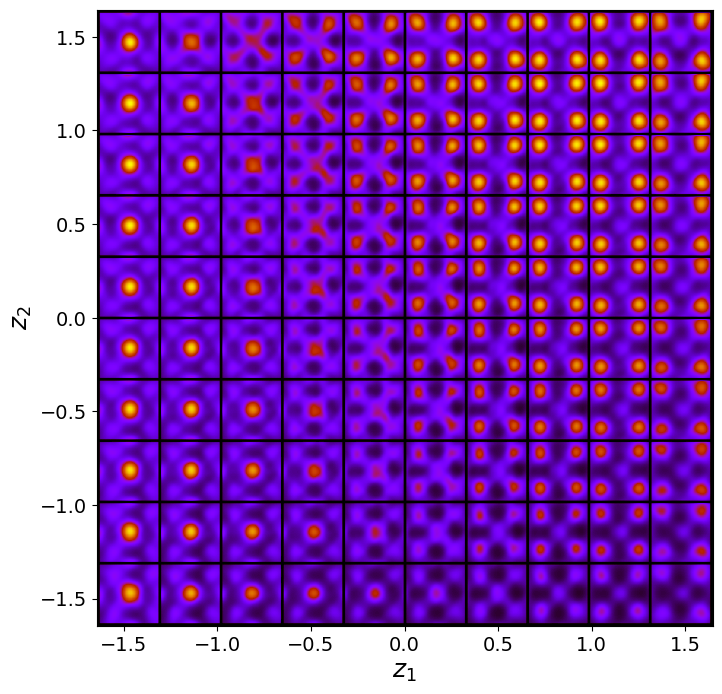

In [15]:
rvae_laten_img = tvae_model.manifold2d(d=10, draw_grid = True, origin = 'lower')

The latent representation of the system is visualized as a grid over the two latent variables $z_1$ and $z_2$. Each grid cell corresponds to a unique combination of values for $z_1$ and $z_2$ , which are decoded to produce corresponding reconstructions in the data space. The smooth and structured transition across the grid indicates that the model has learned a meaningful and continuous mapping between the latent variables and the data space. Variations in the grid reflect changes in the underlying physical structure, such as column type, domain orientation, or material properties.

In [23]:
tvae_z_mean, rvae_z_sd = tvae_model.encode(train_data)
print('no. of defects', tvae_z_mean.shape)

z1 = tvae_z_mean[:, -2]
z2 = tvae_z_mean[:, -1]
tx = tvae_z_mean[:, -4]
ty = tvae_z_mean[:, -3]

no. of defects torch.Size([10917, 4])


In [18]:
def generate_latent_manifold(n=10, decoder=None, target_size=(28, 28)):
    """
    Generate a general latent manifold grid over the entire latent space.
    """
    # Define grid bounds across latent space
    grid_x = np.linspace(min(z1), max(z1), n)
    grid_y = np.linspace(min(z2), max(z2), n)

    # Dynamically infer output shape
    sample_input = torch.tensor([[grid_x[0], grid_y[0]]], dtype=torch.float32)
    with torch.no_grad():
        X_decoded = decoder(sample_input)
    decoded_shape = X_decoded.shape[-2:] if len(X_decoded.shape) > 2 else (X_decoded.shape[-1], X_decoded.shape[-1])

    height, width = target_size
    manifold = np.zeros((height * n, width * n))

    # Generate manifold
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            Z_sample = torch.tensor([[xi, yi]], dtype=torch.float32)
            with torch.no_grad():
                X_decoded = decoder(Z_sample).reshape(decoded_shape)
            resized_image = zoom(X_decoded, zoom=(height / X_decoded.shape[-2], width / X_decoded.shape[-1]))
            manifold[i * height: (i + 1) * height, j * width: (j + 1) * width] = resized_image
    return manifold

In [29]:
# Apply styling for dropdowns
display(HTML("""
    <style>
        .widget-label { font-size: 16px; font-weight: bold; }
        select { font-size: 16px; font-weight: bold; }
    </style>
"""))

# Define dropdown styling
dropdown_style = {'description_width': 'initial'}
dropdown_layout = Layout(width='250px')

# Define available options for Panel B
options = ["z1", "z2", "tx", "ty"]


# Define a dictionary for mapping options to variables
variable_map = {
    "z1": (z1, r"$z_1$", "plasma", "cyan"),
    "z2": (z2, r"$z_2$", "plasma", "magenta"),
    "tx": (tx, r"$t_x$", "plasma", "green"),
    "ty": (ty, r"$t_y$", "plasma", "orange"),
}

def interactive_plot(variable_x, variable_y):
    """Creates a figure with fixed manifold (A) and interactive scatter plot (B)."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # **Panel A (Left) - Fixed Manifold**
    manifold = generate_latent_manifold(n=10, decoder=tvae_model.decode, target_size=(28, 28))
    axes[0].imshow(manifold, cmap="gnuplot2", origin="upper")
    axes[0].set_xlabel(r"$z_1$", fontsize=16, fontweight="bold")
    axes[0].set_ylabel(r"$z_2$", fontsize=16, fontweight="bold")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].text(-0.07, 1, 'a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    # **Panel B (Right) - Interactive Scatter Plot**
    var_x, label_x, cmap_x, color_x = variable_map[variable_x]
    var_y, label_y, cmap_y, color_y = variable_map[variable_y]

    # Scatter plot
    sns.scatterplot(x=var_x, y=var_y, ax=axes[1], color="blue", alpha=0.4, edgecolor="k", s=10)

    # **Fix: Use PyTorch's Variance Instead of NumPy**
    if torch.var(var_x) > 0 and torch.var(var_y) > 0:
        sns.kdeplot(x=var_x.detach().cpu(), y=var_y.detach().cpu(), ax=axes[1], cmap="plasma", levels=50, thresh=0.05, alpha=0.4, fill=False, warn_singular=False)

    axes[1].set_xlabel(label_x, fontsize=16, fontweight="bold")
    axes[1].set_ylabel(label_y, fontsize=16, fontweight="bold")
    axes[1].text(-0.07, 1, 'b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    plt.tight_layout()
    plt.show()

In [ ]:
#| label: app:tVAE_manifold_1

# Create interactive dropdown widgets
interact(interactive_plot, 
         variable_x=widgets.Dropdown(options=options, description="X-Axis", style=dropdown_style, layout=dropdown_layout), 
         variable_y=widgets.Dropdown(options=options, description="Y-Axis", style=dropdown_style, layout=dropdown_layout))

interactive(children=(Dropdown(description='X-Axis', layout=Layout(width='250px'), options=('z1', 'z2', 'tx', …

<function __main__.interactive_plot(variable_x, variable_y)>

In [37]:
# Apply styling for dropdowns
display(HTML("""
    <style>
        .widget-label { font-size: 16px; font-weight: bold; }
        select { font-size: 16px; font-weight: bold; }
    </style>
"""))

# Define dropdown styling
dropdown_style = {'description_width': 'initial'}
dropdown_layout = Layout(width='250px')

# Define available options
options = ["z1", "z2", "tx", "ty", "Ground Truth Px", "Ground Truth Py"]

# Define variables
Px = ground_truth_px[0]  
Py = ground_truth_py[0]  

# Define a dictionary for mapping options to data and plot type
plot_data = {
    "z1": {"data": z1, "type": "scatter", "title": "Latent Variable z1"},
    "z2": {"data": z2, "type": "scatter", "title": "Latent Variable z2"},
    "tx": {"data": tx, "type": "scatter", "title": "Translation X (tx)"},
    "ty": {"data": ty, "type": "scatter", "title": "Translation Y (ty)"},
    "Ground Truth Px": {"data": Px, "type": "image", "title": "Ground Truth Px"},
    "Ground Truth Py": {"data": Py, "type": "image", "title": "Ground Truth Py"},
}

def plot_variable(ax, variable, subplot_label):
    """Plots the selected variable in the given axis."""
    data = plot_data[variable]["data"]
    plot_type = plot_data[variable]["type"]

    if plot_type == "scatter":
        ax.scatter(coms_target[:, 1], coms_target[:, 0], c=data, s=14, cmap='jet', marker="o")
    elif plot_type == "image":
        ax.imshow(data, cmap='jet', origin='lower')

    ax.axis("off")
    ax.text(-0.05, 1, subplot_label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

def plot_two_variables(variable1, variable2):
    """Creates a 1-row, 2-column figure and plots two selected variables."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    plot_variable(axes[0], variable1, 'a)')
    plot_variable(axes[1], variable2, 'b)')
    
    plt.tight_layout()
    plt.show()



In [ ]:
#| label: app:tVAE_latent_1


# Create interactive dropdown widgets
interact(plot_two_variables, 
         variable1=widgets.Dropdown(options=options, description="Variable 1", style=dropdown_style, layout=dropdown_layout), 
         variable2=widgets.Dropdown(options=options, description="Variable 2", style=dropdown_style, layout=dropdown_layout))

interactive(children=(Dropdown(description='Variable 1', layout=Layout(width='250px'), options=('z1', 'z2', 't…

<function __main__.plot_two_variables(variable1, variable2)>